In [ ]:
#This is an implementation of the paper:-
#Walking Direction Estimation Using Smartphone Sensors: A Deep Network-Based Framework
#Published in IEEE TRANSACTIONS ON INSTRUMENTATION AND MEASUREMENT, VOL. 71, 2022
#The authors are IEEE TRANSACTIONS ON INSTRUMENTATION AND MEASUREMENT, VOL. 71, 2022

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
from scipy.signal import decimate, butter, filtfilt, lfilter
from scipy.interpolate import interp1d
from IPython.display import display
from sklearn.decomposition import PCA
from scipy.special import softmax
from pyproj import CRS, Transformer
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score as accuracy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [3]:
# df_accnn = pd.read_csv('/content/drive/MyDrive/Direction_Estimation/Dataset2/TotalAcceleration.csv')
# df_mgmm = pd.read_csv('/content/drive/MyDrive/Direction_Estimation/Dataset2/Magnetometer.csv')
# df_gns = pd.read_csv('/content/drive/MyDrive/Direction_Estimation/Dataset2/Location.csv')

In [4]:
# df_accn = df_accnn.loc[:,['time','seconds_elapsed','x','y','z']]
# df_accn

In [5]:
# df_mgmm

In [6]:
# df_gns

In [7]:
# df_accn

# **Calculating reference GNSS values**

In [8]:
def prepare_interpolated_dfgnss(df_gnss_values):

  #First make the sampling uniform
  #The sampling rate might have very tiny errors due to device issues
  #df_gnss has values missing at some timestamps
  #i.e they are not uniformly space at equal intervals

  df_gnss_values = df_gnss_values.copy(deep=True)
  df_gnss_values['time_interval'] = df_gnss_values['seconds_elapsed'].diff().fillna(0)
  df_gnss_values['interpolated_time'] = df_gnss_values['time_interval'].cumsum()
  interpolate_lat = interp1d(df_gnss_values['interpolated_time'], df_gnss_values['latitude'], kind='linear')
  interpolate_lon = interp1d(df_gnss_values['interpolated_time'], df_gnss_values['longitude'], kind='linear')

  uniform_time = np.arange(df_gnss_values['interpolated_time'].iloc[0], df_gnss_values['interpolated_time'].iloc[-1], 1)
  uniform_df = pd.DataFrame({'seconds': uniform_time})

  uniform_df['latitude'] = interpolate_lat(uniform_time)
  uniform_df['longitude'] = interpolate_lon(uniform_time)

  uniform_df.drop(0,inplace=True)
  uniform_df = uniform_df.reset_index(drop=True)
  df_g = uniform_df.copy(deep=True)

  return(df_g)

In [9]:
def prepare_psi_ref_data(df_gnss_values):

  #First make the sampling uniform
  #The sampling rate might have very tiny errors due to device issues
  #df_gnss has values missing at some timestamps
  #i.e they are not uniformly space at equal intervals

  df_gnss_values = df_gnss_values.copy(deep=True)
  df_gnss_values['time_interval'] = df_gnss_values['seconds_elapsed'].diff().fillna(0)
  df_gnss_values['interpolated_time'] = df_gnss_values['time_interval'].cumsum()
  interpolate_lat = interp1d(df_gnss_values['interpolated_time'], df_gnss_values['latitude'], kind='linear')
  interpolate_lon = interp1d(df_gnss_values['interpolated_time'], df_gnss_values['longitude'], kind='linear')

  uniform_time = np.arange(df_gnss_values['interpolated_time'].iloc[0], df_gnss_values['interpolated_time'].iloc[-1], 1)
  uniform_df = pd.DataFrame({'seconds': uniform_time})

  uniform_df['latitude'] = interpolate_lat(uniform_time)
  uniform_df['longitude'] = interpolate_lon(uniform_time)

  uniform_df.drop(0,inplace=True)
  uniform_df = uniform_df.reset_index(drop=True)
  df_g = uniform_df.copy(deep=True)

  #UTM Zone formula is = 31 + Longitude/6
  UTM = int(31 + (df_gnss_values['longitude'][0])/6)

  # Define the coordinate reference systems
  wgs84 = CRS.from_epsg(4326)  # WGS84 geographic coordinate system
  utm = CRS.from_string('+proj=utm +zone={} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'.format(UTM))
  # UTM zone is 43N for Pune

  # Create a transformer to convert from WGS84 to UTM zone 10N
  transformer = Transformer.from_crs(wgs84, utm, always_xy=True)

  df_gnss1 = df_g.copy(deep=True)

  df_gnss1['east'], df_gnss1['north'] = transformer.transform(df_gnss1['longitude'].values, df_gnss1['latitude'].values)

  # Apply linear regression on sliding windows for north and east components
  window_size = 5
  df_gnss1['north_vel'] = df_gnss1['north'].rolling(window=window_size).apply(lambda x: linregress(range(window_size), x)[0], raw=True)
  df_gnss1['east_vel'] = df_gnss1['east'].rolling(window=window_size).apply(lambda x: linregress(range(window_size), x)[0], raw=True)
  df_gnss1['motion_heading'] = np.arctan2(df_gnss1['north_vel'],df_gnss1['east_vel'])

  df_psi_ref = df_gnss1.copy(deep=True)

  df_psi_ref = df_gnss1.copy(deep=True)
  df_psi_ref.drop(index = [0,1,2,3,4,5,6],inplace=True)#Removing the first 4 rows as
  #they contain NaN values
  df_psi_ref.reset_index(inplace=True, drop=True)

  psi_reference = torch.rad2deg(torch.tensor(np.array(df_psi_ref.loc[:,'motion_heading'])))
  # psi_reference = torch.tensor(np.array(filtered_data))
  #psi_reference will be used in the training model
  return(psi_reference)



# **Calculating the Gravity Vector**

In [10]:
def prepare_gamma_data(df_acceleration1,gnss_length):

  #gnss_length is the length of the length of the
  #prepared reference gnss values

  df_acceleration = df_acceleration1.loc[:,['time','seconds_elapsed','x','y','z']]

  #The 'time' column is actually the timestamp
  #The accn vector will be defined and also updated for every 255 samples
  #N=Fs * T where Fs=50Hz (sampling rate) and T = 5.1 sec (Sliding window length)

  df_acc_op = df_acceleration.copy(deep=True)
  listt = []

  for i in range(len(df_acc_op)):
    sec = m.ceil(df_acc_op.loc[i,'seconds_elapsed'])
    listt.append(sec)

  df_acc_op['seconds'] = listt

  acc_vec = []
  for i in range(1,gnss_length+6):
    temp_list = []
    if(i==1):
      dfp = df_acc_op[df_acc_op['seconds']==i]
    elif(i==2):
      dfp = df_acc_op[df_acc_op['seconds'].isin([i, i-1])]
    elif(i==3):
      dfp = df_acc_op[df_acc_op['seconds'].isin([i, i-1,i-2])]
    elif(i==4):
      dfp = df_acc_op[df_acc_op['seconds'].isin([i, i-1,i-2,i-3])]
    else:
      dfp = df_acc_op[df_acc_op['seconds'].isin([i, i-1, i-2, i-3, i-4])]


    ax = dfp['x'].mean()
    ay = dfp['y'].mean()
    az = dfp['z'].mean()
    vec = np.array([ax,ay,az])

    normalized_vec = vec/np.linalg.norm(vec)

    acc_vec.append([float(i),normalized_vec[0],normalized_vec[1],normalized_vec[2]])


  df_acc_vec_final = pd.DataFrame(data=acc_vec,columns=['seconds','x','y','z'])
  df_acc_vec_final.drop([0,1,2,3,4],inplace=True)
  df_acc_vec_final = df_acc_vec_final.reset_index(drop=True)

  gm = torch.tensor(np.array(df_acc_vec_final.loc[:,['x','y','z']]))
  return(gm)
  #gm can be used directly in the model

# **Filtering of Magnetometer values**

In [11]:
def prepare_mgm_data(df_magnetometer1,gnss_length):
  #Cut-off frequency for low-pass filtering = 0.25Hz
  #Order of Butterworth filter = 4 (To have better results as it would be smoother)

  df_magnetometer=df_magnetometer1.loc[:,['time','seconds_elapsed','x','y','z']]

  cutoff_frequency = 0.25
  order = 4
  b, a = butter(order, cutoff_frequency, btype='low', analog=False)
  # Apply the filter to the magnetic field values
  filtered_x = filtfilt(b, a, np.array(df_magnetometer['x']), method='pad', axis=0)
  filtered_y = filtfilt(b, a, np.array(df_magnetometer['y']), method='pad', axis=0)
  filtered_z = filtfilt(b, a, np.array(df_magnetometer['z']), method='pad', axis=0)

 #Thus we cannot get exactly 368 values. So we take 371 values and
  #Remove 3 values
  #Fs = 49
  # Downsample the filtered values to 1Hz with 'iir' filter type

  Fs = 50
  downsampled_x = decimate(filtered_x, q=int(Fs/1), ftype='iir')
  downsampled_y = decimate(filtered_y, q=int(Fs/1), ftype='iir')
  downsampled_z = decimate(filtered_z, q=int(Fs/1), ftype='iir')

  df_magnetometer_filtered = pd.DataFrame({ 'seconds_elapsed':[float(i)
  for i in range(len(downsampled_x))], 'x': list(downsampled_x),
                                   'y': list(downsampled_y),
                                   'z': list(downsampled_z)})
  #So that we will actually be considering the data from the 6th second
  #Because our deep model will give output, starting from
  #The 6th second
  df_magnetometer_filtered.drop([i for i in range(len(downsampled_x)-gnss_length)],inplace=True)
  df_magnetometer_filtered = df_magnetometer_filtered.reset_index(drop=True)

  mu = torch.tensor(np.array(df_magnetometer_filtered.loc[:,['x','y','z']]))

  return(mu)
  #To use in Deep Model

# **Deep Network And Functions**

Functions used in deep network

In [12]:
def pointwise_tanh(data):
    return torch.tanh(data)

def spatial_decorrelation(data):
  # print("Shape of the the the data is",data.shape)
  cov = torch.matmul(data, data.transpose(1, 2)) / torch.tensor(data.shape[1], dtype=torch.float32)
  # print(cov.shape)
  eig_vals, eig_vecs = torch.linalg.eigh(cov)
  sorted_index = torch.argsort(eig_vals, descending=True)
  sorted_eig_vals = eig_vals[0, sorted_index]  # Apply indexing fix here
  sorted_eig_vecs = eig_vecs[:, sorted_index]

  # Select the top 3 eigen vectors
  transformation_matrix = sorted_eig_vecs[:, :3].to(torch.float32)

  # Transpose the data tensor
  data_transposed = data.transpose(1,2).to(torch.float32)
  # print("Data shape",data.shape)
  # print("Data transpose:",data_transposed.shape)

  # Perform matrix multiplication
  # print(data_transposed.shape, transformation_matrix.shape)
  acc_decorr = torch.matmul(data_transposed, transformation_matrix)

  # Transpose the result
  # print("This is acc_decorr shape: before transpose",acc_decorr.shape)
  acc_decorr = acc_decorr.transpose(1, 2)
  # print("This is acc_decorr shape:",acc_decorr.shape)
  # Reshape the tensor
  acc_decorr = acc_decorr.reshape((3, 255))

  return(acc_decorr)

def inverse_spatial_decorrelation(data):
  cov = torch.matmul(data, data.transpose(1, 2)) / torch.tensor(data.shape[1], dtype=torch.float32)
  eig_vals, eig_vecs = torch.linalg.eigh(cov)
  sorted_index = torch.argsort(eig_vals, descending=True)
  sorted_eig_vals = eig_vals[0,sorted_index]
  sorted_eig_vecs = eig_vecs[:, sorted_index]

  # Select the top 3 eigen vectors
  transformation_matrix = sorted_eig_vecs[:, :3].to(torch.float32)
  inv_transformation_matrix = torch.linalg.inv(transformation_matrix)

  return(inv_transformation_matrix)

In [13]:
class motion_network_class_test(nn.Module):
  def __init__(self):
      super(motion_network_class_test, self).__init__()
      self.pt_wise = nn.Linear(3, 8)
      self.tconv1 = nn.Conv1d(8, 8, kernel_size=6, stride=3)
      self.fc1_layer1 = nn.Linear(8, 16)
      self.fc1_layer2 = nn.Linear(16, 8)
      self.tconv2 = nn.Conv1d(8, 8, kernel_size=6, stride=3)
      self.fc2_layer1 = nn.Linear(8, 16)
      self.fc2_layer2 = nn.Linear(16, 8)
      self.tconv3 = nn.Conv1d(8, 8, kernel_size=6, stride=3)
      self.fc3_layer1 = nn.Linear(8, 16)
      self.fc3_layer2 = nn.Linear(16, 8)
      self.fc_final = nn.Linear(192, 3)

  def unit_model(self, x):
      # x = x.reshape(1,3,255)
      x1 = x.clone()
      # print("x1 shape",x1.shape)
      x = spatial_decorrelation(x)
      x = self.pt_wise(x.transpose(0, 1)).tanh().reshape(8,255)
      # print(x.shape)
      x = self.tconv1(x)
      # print(x.shape)
      H1 = x.transpose(0,1)

      # Attention Block 1
      att1_layer1 = self.fc1_layer1(H1)
      att1_layer2 = att1_layer1.tanh()
      att1_layer3 = self.fc1_layer2(att1_layer2)
      att1_layer4 = F.softmax(att1_layer3, dim=0)
      A11 = att1_layer4
      H11 = H1.transpose(0,1)
      # print(H11.shape,A11.shape)
      G1 = torch.matmul(H11, A11)
      G1 = G1.reshape(-1)

      # T-Conv No.2
      output2 = self.tconv2(x)

      # Attention Block 2
      output22 = output2.transpose(0,1)
      att2_layer1 = self.fc2_layer1(output22)
      att2_layer2 = att2_layer1.tanh()
      att2_layer3 = self.fc2_layer2(att2_layer2)
      att2_layer4 = F.softmax(att2_layer3, dim=0)
      # print(att2_layer4.shape)
      A22 = att2_layer4
      H22 = output22.transpose(0,1)
      G2 = torch.matmul(H22, A22)
      G2 = G2.reshape(-1)

      # T-Conv No.3
      output3 = self.tconv3(output2)

      # Attention Block 3
      output33 = output3.transpose(0,1)
      att3_layer1 = self.fc3_layer1(output33)
      att3_layer2 = att3_layer1.tanh()
      att3_layer3 = self.fc3_layer2(att3_layer2)
      att3_layer4 = F.softmax(att3_layer3, dim=0)
      A33 = att3_layer4
      H33 = output33.transpose(0,1)
      G3 = torch.matmul(H33, A33)
      G3 = G3.reshape(-1)

      # Concatenate and flatten
      # print(G1.shape)
      flat_array = torch.cat((G1, G2, G3), dim=0)
      flatten_arr = flat_array.reshape(1, 192)
      # print(flatten_arr.shape)

      # Apply a fully connected layer
      full_connected = self.fc_final(flatten_arr)
      # print(full_connected.shape)
      OP = full_connected.transpose(0, 1)
      # print(OP.shape)

      # Inverse Spatial Decorrelation
      # print(x1.shape)
      inv_trans_mat = inverse_spatial_decorrelation(x1)
      lamb = torch.matmul(inv_trans_mat, OP)
      # print(lamb.shape)

      return lamb


#forward method is like train method
#It will be used only for training

  def geometric_calculations(self,Accn,Gamma,Mu):

    accn_tensor = Accn.clone()
    accn_tensor = accn_tensor.reshape(1,3,255)
    gamma_tensor = Gamma.clone()
    mu_tensor = Mu.clone()


    lambda_vector = self.unit_model(accn_tensor)
    lambda_nn = lambda_vector.reshape(1,3)
    gamma_nn = gamma_tensor.reshape(1,3)
    mu_nn = mu_tensor.reshape(1,3)

    s_nn = torch.linalg.cross(gamma_nn,mu_nn)
    r_nn = torch.linalg.cross(s_nn,gamma_nn)

    lambda_nn_T = lambda_nn.reshape(3,1).double()
    x_nn = torch.matmul(s_nn,lambda_nn_T)
    y_nn = torch.matmul(r_nn,lambda_nn_T)

    ps_i = torch.atan2(x_nn,y_nn)
    ps_i = torch.rad2deg(ps_i)

    # print(ps_i.shape,lambda_vector.shape)

    return(ps_i,lambda_vector)


  def forward(self,X):

    Accn = X[0]
    Gamma = X[1]
    Mu = X[2]

    psi, lambda_vec = self.geometric_calculations(Accn,Gamma,Mu)

    #We return psi estimated value and lambda vector to use cost functions

    return(psi,lambda_vec)


Loss and Regularization Function

In [14]:
def loss_function(y_true,y_pred):
  arg = (y_true-y_pred)/2
  arg1 = torch.sin(arg)
  rloss = torch.square(arg1)

  return(rloss)

def regularization(lambda_vec,gamma_vec):
    lambda_vec = lambda_vec.reshape(-1, 3)
    term1 = torch.sum(torch.square(torch.sum(gamma_vec * lambda_vec, dim=1)))
    term2 = torch.sum(torch.square(torch.norm(lambda_vec, dim=1)))
    term3 = torch.sum(torch.square(torch.log(torch.norm(lambda_vec, dim=1))))
    regularization_loss = term1 / term2 + term3
    # rms = torch.sqrt(torch.mean(torch.square(regularization_loss)))
    return(regularization_loss)

In [15]:
def err(y_true,y_pred):
  mean_error = torch.abs(torch.fmod(torch.deg2rad(y_true - y_pred) + torch.pi, 2 * torch.pi) - torch.pi)
  mean_error = torch.rad2deg(mean_error.mean())
  return(mean_error)

# **Data Preparation and Training**

In [16]:
def prepare_acc_data(acc_data,df_gnss):

  #Requires df_gnss in dataframe format

  accn = []

  for i in range(8, int(df_gnss.loc[len(df_gnss)-1,'seconds'])+1):
    filtered_acc = acc_data[ acc_data['seconds_elapsed'] < float(i) ]
    data = filtered_acc[-255:]
    data1 = data.loc[:,['x','y','z']]
    data2 = np.array(data1)
    accn.append(data2)

  accn1 = torch.tensor(np.array(accn))
  accn2 = accn1.transpose(1,2)
  return(accn2)

class MotionDatasetTest(Dataset):
    def __init__(self, acceleration, gam_vector, mu_vector):
        self.acceleration = acceleration
        self.gam_vector = gam_vector
        self.mu_vector = mu_vector

    def __len__(self):
        return len(self.gam_vector)

    def __getitem__(self, idx):
        acceleration_item = self.acceleration[idx]
        gamma = self.gam_vector[idx]
        mu_vector = self.mu_vector[idx]
        return(acceleration_item, gamma, mu_vector)

In [17]:
def train_model(motion_network_model_test,raw_accn, prepared_gamma, prepared_mu,
                prepared_psi_ref,raw_gnss, num_epochs=10):

  df_gnss_for_acc_data = prepare_interpolated_dfgnss(raw_gnss)
  accn_data = prepare_acc_data(raw_accn,df_gnss_for_acc_data)
  motion_dataset_test = MotionDatasetTest(accn_data, prepared_gamma, prepared_mu)
  batch_size_test = 1
  # We set batch_size_test = 1 always because our model works according
  # to batch_size = 1
  data_loader_test = DataLoader(motion_dataset_test, batch_size=batch_size_test, shuffle=False)

  loss_list =[]

  optimizer = optim.AdamW(motion_network_model_test.parameters(), lr=0.003, weight_decay=0.01)

  for epoch in range(num_epochs):
      # Set the model to train mode
    motion_network_model_test.train()

    epoch_loss = 0

    for i, (batch_acceleration, batch_gamma, batch_mu_vector) in enumerate(data_loader_test):
      # batch_acceleration has shape (batch_size, 3, 255)
      # batch_gamma has shape (batch_size, 3)
      # batch_mu_vector has shape (batch_size, 3)
      inp_data = [batch_acceleration, batch_gamma, batch_mu_vector]
      #Pass this to the model
      output_psi,output_lamb = motion_network_model_test(inp_data)
      # print(output_psi.shape, output_lamb.shape)
      sine_loss = loss_function(prepared_psi_ref[i],output_psi)
      regularization_loss = regularization(output_lamb,batch_gamma)
      # loss = sine_loss + regularization_loss
      loss = sine_loss + regularization_loss
      epoch_loss+=loss
      # print(loss.shape)
      loss.backward()
      optimizer.step()

      optimizer.zero_grad()
    loss_list.append(epoch_loss/len(prepared_gamma))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_list[epoch].item()}")

  lossy_list = [i.detach().item() for i in loss_list]
  plt.plot([i for i in range(len(lossy_list))],lossy_list)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("Loss with epochs")
  plt.show()

# **Testing and Evaluation**

In [18]:
def model_test(model,raw_accn, prepared_gamma, prepared_mu,
                prepared_psi_ref,raw_gnss):

  df_gnss_for_acc_data = prepare_interpolated_dfgnss(raw_gnss)
  accn_data = prepare_acc_data(raw_accn,df_gnss_for_acc_data)
  motion_dataset_test = MotionDatasetTest(accn_data, prepared_gamma, prepared_mu)
  batch_size_test = 1
  # We set batch_size_test = 1 always because our model works according
  # to batch_size = 1
  data_loader_test = DataLoader(motion_dataset_test, batch_size=batch_size_test, shuffle=False)

  psi_estimated = []
  model.eval()
  for i, (batch_acceleration, batch_gamma, batch_mu_vector) in enumerate(data_loader_test):
    inp_data = [batch_acceleration, batch_gamma, batch_mu_vector]
    #Pass this to the model
    psi_new,_ = model(inp_data)
    psi_estimated.append(psi_new)

  psi_estimated = torch.tensor(psi_estimated)

  return(psi_estimated)


In [19]:
import numpy as np
from scipy.ndimage import median_filter

def circular_median_filter(arr, window_size):
    # Pad the array to handle circular wrapping
    padded_arr = np.concatenate((arr[-window_size:], arr, arr[:window_size]))

    # Apply median filter
    smoothed_arr = median_filter(padded_arr, size=window_size, mode='wrap')

    # Return the smoothed array without the padded regions
    return smoothed_arr[window_size:-window_size]

def moving_average_filter(signal, window_size, iterations):
    filtered_signal = signal.copy()  # Create a copy of the original signal
    for _ in range(iterations):
        filtered_signal = np.convolve(filtered_signal, np.ones(window_size), mode='same') / window_size
    return filtered_signal

def circular_lowpass_filter(arr, cutoff_frequency):
    # Perform circular shift to align the signal
    shifted_arr = np.fft.ifftshift(arr)

    # Perform Fourier transform
    spectrum = np.fft.fft(shifted_arr)

    # Apply low-pass filter in the frequency domain
    num_samples = len(arr)
    frequencies = np.fft.fftfreq(num_samples)
    mask = np.abs(frequencies) <= cutoff_frequency
    spectrum_filtered = spectrum * mask

    # Perform inverse Fourier transform
    filtered_arr = np.fft.ifft(spectrum_filtered)

    # Perform circular shift to revert back to the original alignment
    filtered_arr = np.fft.fftshift(filtered_arr)

    return np.array(filtered_arr)

# Apply Circular Low-Pass Filter



In [20]:
def plot_and_eval(psi_ground, psi_estimated, window_size):

  est_angle1 = np.array(psi_estimated.detach())
  ref_angle1 = np.array(psi_ground)

  est_angle1 = circular_median_filter(est_angle1, window_size)
  ref_angle1 = circular_median_filter(ref_angle1, window_size)

  est_angle1 = moving_average_filter(est_angle1,5,2)
  ref_angle1 = moving_average_filter(ref_angle1,5,2)

  mean_error = np.abs(np.mod(np.radians(est_angle1-ref_angle1)+np.pi,2*np.pi)-np.pi)
  mean_error = np.degrees(mean_error.mean())
  print("The mean absolute error is: ", mean_error)

  plt.figure(figsize=(25,5))
  plt.plot(est_angle1,label='Estimated')
  plt.plot(np.array(ref_angle1),label='Ground truth')
  plt.legend()
  plt.title("Plot of Estimated and Ground Values")
  plt.show()

# **Whole Pipeline**

Pipeline Functions

In [21]:
def direction_estimation_model_train(model, accn_df,mgm1_df,gnss_df,n_epochs=10):
  ref_psi = prepare_psi_ref_data(gnss_df)
  gm1 = prepare_gamma_data(accn_df,ref_psi.shape[0])
  mu1 = prepare_mgm_data(mgm1_df,ref_psi.shape[0])
  train_model(model, raw_accn=accn_df, prepared_gamma=gm1, prepared_mu=mu1, prepared_psi_ref=ref_psi,raw_gnss=gnss_df, num_epochs=n_epochs)



In [22]:
def direction_estimation_model_test(model, accn_df,mgm1_df,gnss_df):

  ref_psi = prepare_psi_ref_data(gnss_df)
  gm1 = prepare_gamma_data(accn_df,ref_psi.shape[0])
  mu1 = prepare_mgm_data(mgm1_df,ref_psi.shape[0])

  psi_est = model_test(model=model,raw_accn=accn_df, prepared_gamma=gm1, prepared_mu=mu1, prepared_psi_ref=ref_psi,raw_gnss=gnss_df)
  plot_and_eval(ref_psi, psi_est, window_size=5)
  #Returns estimated psi angles
  return(psi_est)

Name of the model which will be universally trained in this colab notebook is
d_est_model

In [23]:
#Initiate a model
d_est_model = nn.Sequential(motion_network_class_test())

Pune Dataset2

Epoch [1/10], Loss: 1.012724322580216
Epoch [2/10], Loss: 1.4641994199201374
Epoch [3/10], Loss: 1.6652910149893145
Epoch [4/10], Loss: 1.5701305076383376
Epoch [5/10], Loss: 1.3492027458851357
Epoch [6/10], Loss: 0.8442244731608136
Epoch [7/10], Loss: 1.3802641133887341
Epoch [8/10], Loss: 1.6069046915910001
Epoch [9/10], Loss: 1.2200954512262367
Epoch [10/10], Loss: 1.791711272797644


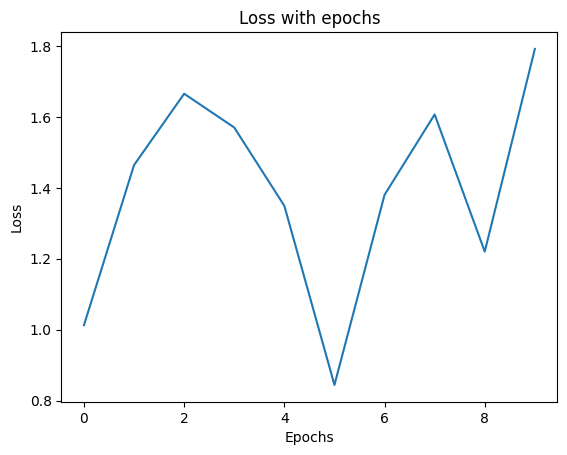

The mean absolute error is:  147.6959636448579


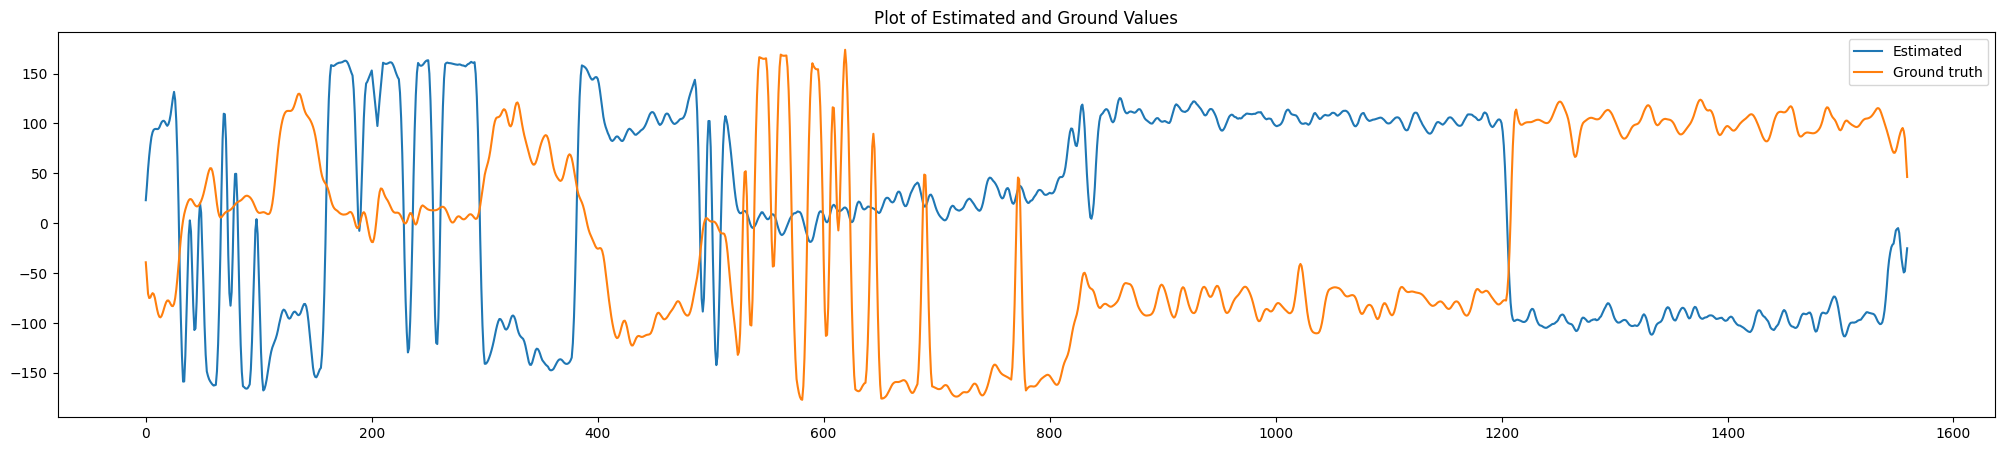

In [24]:
accn_df_pune2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation/Dataset2/TotalAcceleration.csv')
mgm_df_pune2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation/Dataset2/Magnetometer.csv')
gnss_df_pune2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation/Dataset2/Location.csv')

direction_estimation_model_train(d_est_model, accn_df_pune2, mgm_df_pune2, gnss_df_pune2,n_epochs=10)
psi_est_pune2 = direction_estimation_model_test(d_est_model, accn_df_pune2, mgm_df_pune2, gnss_df_pune2)

KT1

Epoch [1/10], Loss: 1.7573371403218594
Epoch [2/10], Loss: 1.2965635509925901
Epoch [3/10], Loss: 1.600313363799578
Epoch [4/10], Loss: 2.1856171511920266
Epoch [5/10], Loss: 1.4895807705368047
Epoch [6/10], Loss: 1.5804264571702622
Epoch [7/10], Loss: 1.433737176916293
Epoch [8/10], Loss: 1.5157566843975951
Epoch [9/10], Loss: 1.8446533373877116
Epoch [10/10], Loss: 1.1159453671216633


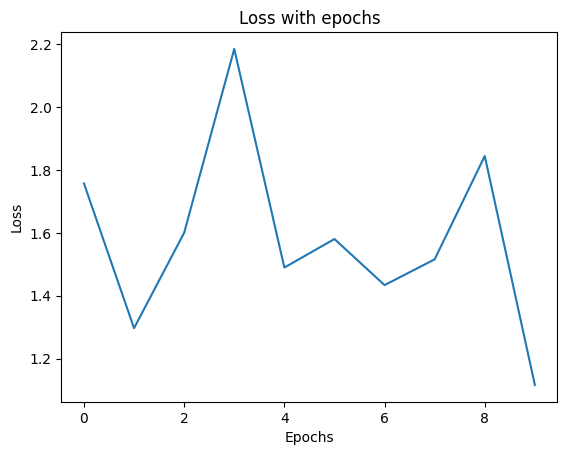

The mean absolute error is:  73.93677501868196


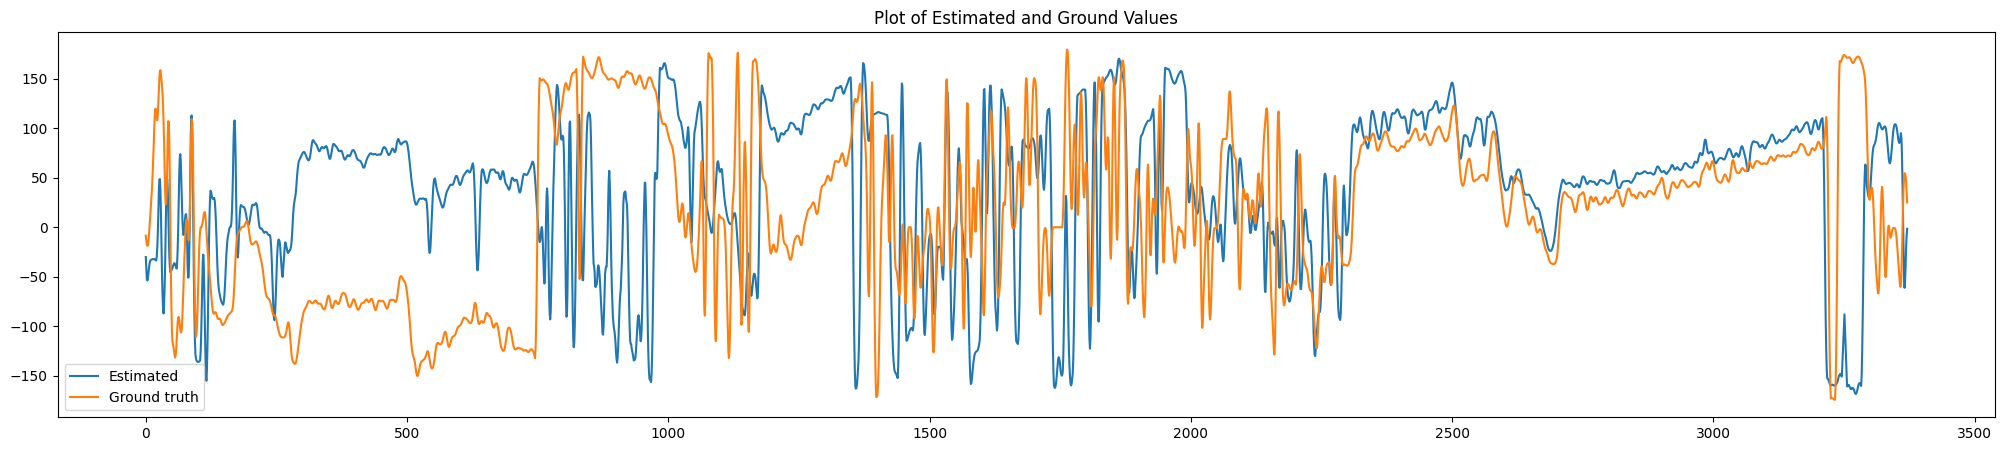

In [25]:
accn_df_kt1 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_1/TotalAcceleration.csv')
mgm_df_kt1 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_1/Magnetometer.csv')
gnss_df_kt1 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_1/Location.csv')

direction_estimation_model_train(d_est_model, accn_df_kt1, mgm_df_kt1, gnss_df_kt1,n_epochs=10)

psi_est_kt1 = direction_estimation_model_test(d_est_model, accn_df_kt1, mgm_df_kt1, gnss_df_kt1)

KT2

The mean absolute error is:  92.36184623610531


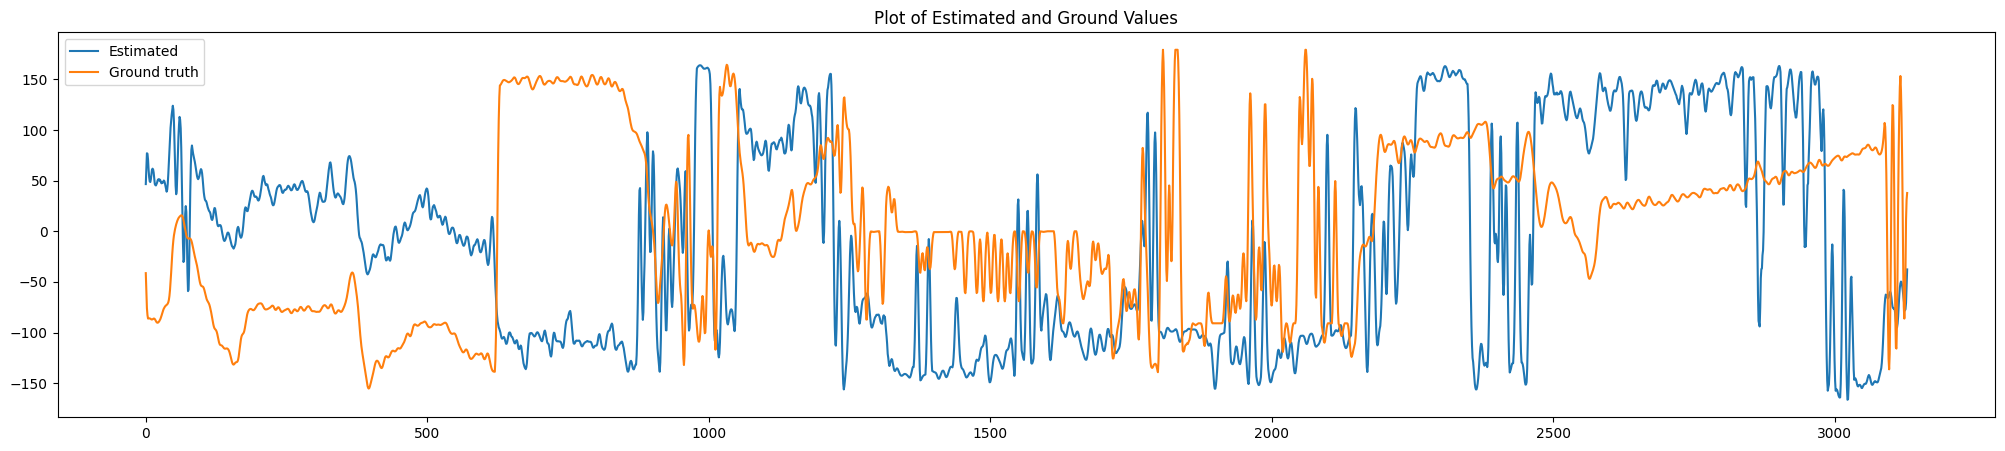

In [26]:
accn_df_kt2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_2/TotalAcceleration.csv')
mgm_df_kt2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_2/Magnetometer.csv')
gnss_df_kt2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_2/Location.csv')

# direction_estimation_model_train(d_est_model, accn_df_kt2, mgm_df_kt2, gnss_df_kt2,n_epochs=10)

psi_est_kt2 = direction_estimation_model_test(d_est_model, accn_df_kt2, mgm_df_kt2, gnss_df_kt2)

KT3 - Faulty Dataset

The mean absolute error is:  64.20682388036752


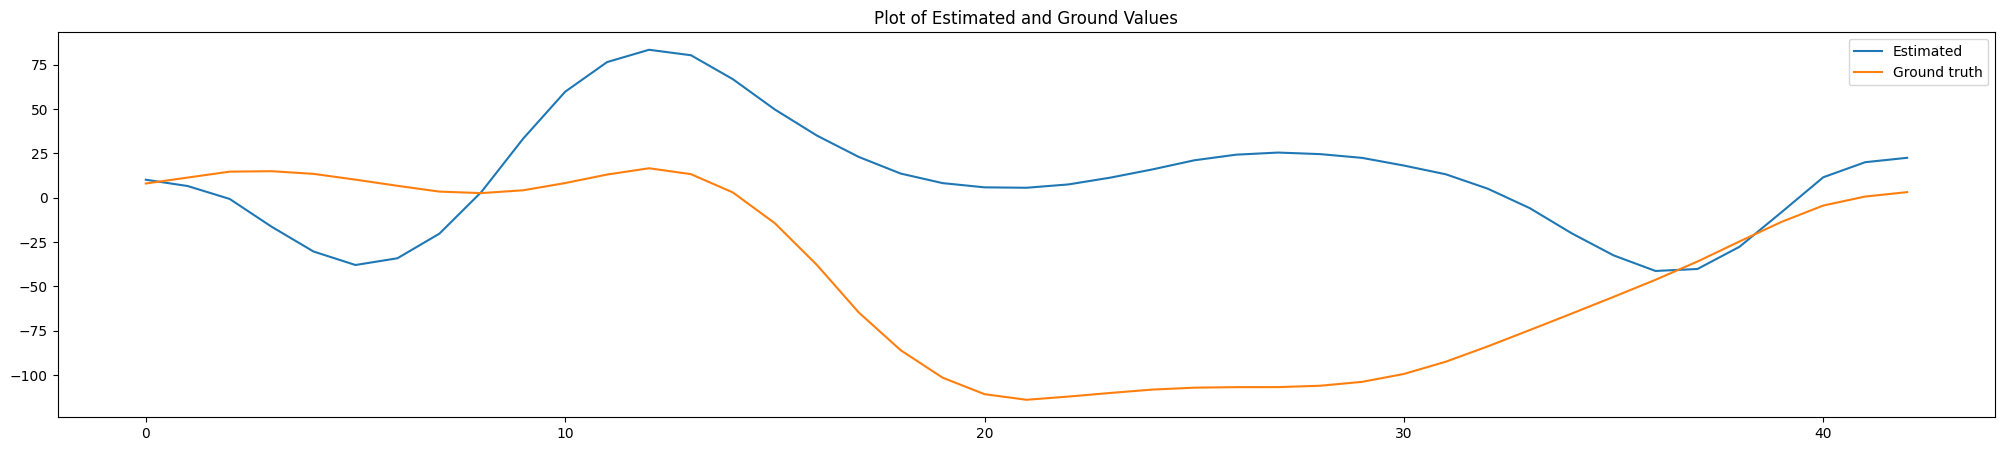

In [27]:
accn_df_kt3 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_3/TotalAcceleration.csv')
mgm_df_kt3 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_3/Magnetometer.csv')
gnss_df_kt3 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/KT to main gate to AIDS to KB to KT to G3/Dataset_3/Location.csv')

# direction_estimation_model_train(d_est_model, accn_df_kt3, mgm_df_kt3, gnss_df_kt3,n_epochs=10)

psi_est_kt3 = direction_estimation_model_test(d_est_model, accn_df_kt3, mgm_df_kt3, gnss_df_kt3)

Ph_dept_to_Mess1

Ph_dept_to_Mess2

The mean absolute error is:  64.20682388036752


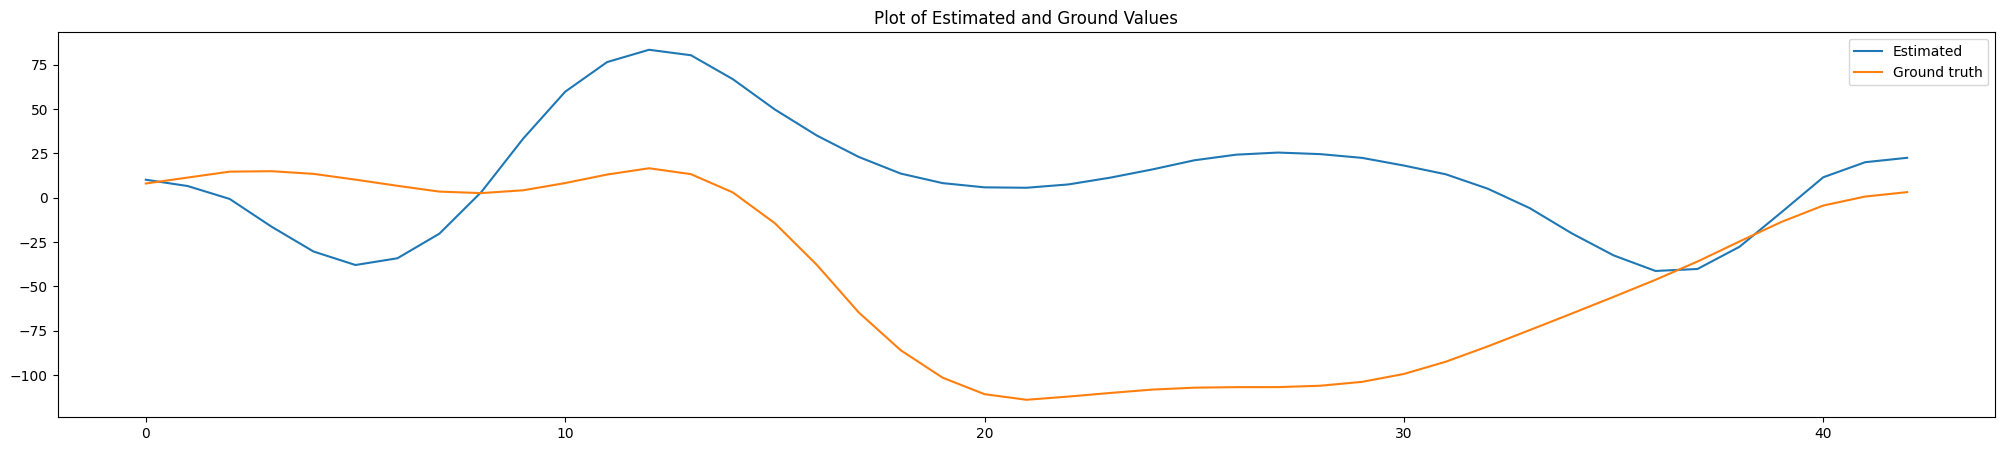

In [28]:
accn_df_ph2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/Phy_dept_to_CSE_dept_to_New_Mess/Dataset_2/TotalAcceleration.csv')
mgm_df_ph2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/Phy_dept_to_CSE_dept_to_New_Mess/Dataset_2/Magnetometer.csv')
gnss_df_ph2 = pd.read_csv('/content/drive/MyDrive/Direction_Estimation Datasets/Phy_dept_to_CSE_dept_to_New_Mess/Dataset_2/Location.csv')

# direction_estimation_model_train(d_est_model, accn_df_ph2, mgm_df_ph2, gnss_df_ph2,n_epochs=10)

psi_est_ph1 = direction_estimation_model_test(d_est_model, accn_df_ph2, mgm_df_ph2, gnss_df_ph2)

Pune3